# von Karman beam with clamped-free BCs


We are using the Taylor coefficients extracted via SSMTool using the normal form style parametrization. 

In [3]:
import numpy as np
from scipy.io import loadmat

In [4]:
import matplotlib.pyplot as plt

In [5]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [6]:
src_real = 'real_FRC/'


Load SSM coeffs

In [7]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_order18_multiindex.mat')


In [8]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)
base = [p1, p2]

In [9]:
import taylor_to_pade

In [10]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

In [11]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [12]:
outdof = 28


In [13]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [14]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [15]:
sample_rs = np.linspace(1e-7, 1e-3, 1000)

In [16]:
orders = np.arange(3, 10, 1)


In [17]:
calib_from_ssmtool = np.abs(0.02425)


In [18]:
colormap = plt.cm.copper

In [19]:
from scipy import interpolate

In [20]:
from scipy.optimize import minimize

### Extract the Taylor series

In [21]:
import matplotlib as mpl

In [22]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

Only select 3 amplitudes to compare to:

In [23]:
selected_ = [1, 4, 8] 

In [24]:
sample_rs = np.linspace(1e-7, 1e-2, 10000)
depsilons = np.linspace(5e-4, 5e-2, 10) 

# Forced response as periodic orbits of the reduced dynamics

On a two-dimensional non-resonant SSM, the reduced dynamics in normal form can be written as 

\begin{align}
    \dot{\rho} &= \kappa(\rho)\rho + \varepsilon f \sin \psi \\
    \dot{\psi} &= \omega(\rho) - \Omega + \varepsilon f \frac{1}{\rho} \cos \psi,
\end{align}
where we have introduced the phase lag $\psi = \theta - \Omega t$ and the forcing amplitude $f$ is the projection of the external forcing amplitude. 
The Taylor coefficients of $\kappa(\rho)$, $\omega(\rho)$ are computed using ```SSMTool``` and so is the the projected forcing amplitude $\varepsilon f$. 


The forced response of the system is then obtained as the fixed points of this system, i.e., $\dot{\rho} = \dot{\psi} = 0$. The amplitude $\rho_*$ of the response satisfies the equation
\begin{equation}
    \left(\Omega - \omega(\rho_*)\right)^2 - \frac{\varepsilon^2 f^2}{\rho_*^2} + \kappa(\rho_*)^2 = 0.
\end{equation}

We can rearrange this for $\Omega$ as 

$$
\Omega =  \omega(\rho_*) \pm \sqrt{\frac{\varepsilon^2 f^2}{\rho_*^2} - \kappa(\rho_*)^2 }
$$

## Order-16 SSM-reduced model

In [25]:

o2 = 16 
ind2 = -1
parametrization_taylor = taylor_to_pade.utils.generate_list_of_taylor_approximants(parametrization_expressions, base,
                                                                max_order = o2)

red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables = taylor_to_pade.utils.compute_polar_reduced_dyn_Taylor(reduced_dynamics_expressions, base, max_order = o2)


For the backbone curve, we get the response of the conservative system:

In [26]:
backbone_taylor = []
for r in sample_rs:
    backbone_taylor.append(taylor_to_pade.utils.get_resp_at_r(r,0, parametrization_taylor))


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_33604/2286961508.py:15: RuntimeWarning: invalid value encountered in sqrt
  OmegaFm = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_33604/2286961508.py:16: RuntimeWarning: invalid value encountered in sqrt
  OmegaFp = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))


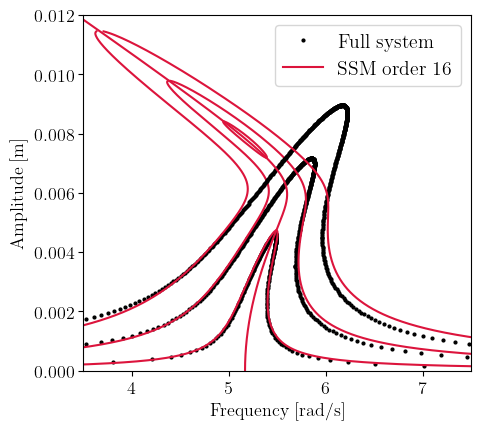

In [27]:
fig = plt.figure(figsize = (5,4.5))
ax = fig.add_subplot(111)
flag = True
for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
    bd = loadmat(src_real + '/data_%s/bd_nd.FRC0.0005/bd.mat' %(i+1))['bd_data']
    # coco output:
    bd_data = bd[3,1] 
    omega = bd_data[1:,7] # frequencies
    experimental_omega = np.array(omega, dtype = float)
    response = np.array(bd_data[1:,26]) # coordinates of the periodic orbit
    experimental_amplitude = [np.max(np.abs(r[outdof,:])) for r in response]
    
    OmegaFm = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    OmegaFp = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    if flag:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4, label = 'Full system')
    else:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4)
    flag = False
    ax.plot(OmegaFm(sample_rs), backbone_taylor ,'-', c = 'crimson')
    ax.plot(OmegaFp(sample_rs), backbone_taylor,'-', c='crimson')
ax.plot(frequency_Taylor.numpy_function(sample_rs), backbone_taylor, '-', c='crimson',  label = 'SSM order 16')

ax.set_xlim(3.5, 7.5)
ax.set_ylim(0, 0.012)

ax.legend(loc= 'upper right', fontsize = 14.2)
ax.set_xlabel('Frequency [rad/s]')
ax.set_ylabel('Amplitude [m]')

fig.tight_layout()




## gSSM-reduced model

To avoid singularities, we use a [5/4] approximant for the parametrization and [5/5] approximants for the reduced dynamics. 

However, we need a higher-order Taylor approximant for this to be accurate. 

In [28]:
parametrization_taylor_18 = taylor_to_pade.utils.generate_list_of_taylor_approximants(parametrization_expressions, base,
                                                                max_order = 18)

In [29]:
parametrization_pade = taylor_to_pade.utils.generate_list_of_pade_approximants(parametrization_taylor_18, base,
                                                                               order_num =5, order_denom= 4, use_robust=True)
frequency_Pade, damping_Pade = taylor_to_pade.utils.compute_polar_reduced_dyn_pade(frequency_Taylor, damping_Taylor, radial_variables, 
                                                                                   order_num=5, order_denom=5, use_robust=True)
damping_curve_pade = lambda x: np.squeeze(-damping_Pade.evaluate(x.reshape(-1,1)) / np.squeeze(x) )

In [30]:
backbone_pade = []
for r in sample_rs:
    backbone_pade.append(taylor_to_pade.utils.get_resp_at_r(r, 0, parametrization_pade))

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_33604/155481354.py:28: RuntimeWarning: invalid value encountered in sqrt
  OmegaFm_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_33604/155481354.py:29: RuntimeWarning: invalid value encountered in sqrt
  OmegaFp_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))


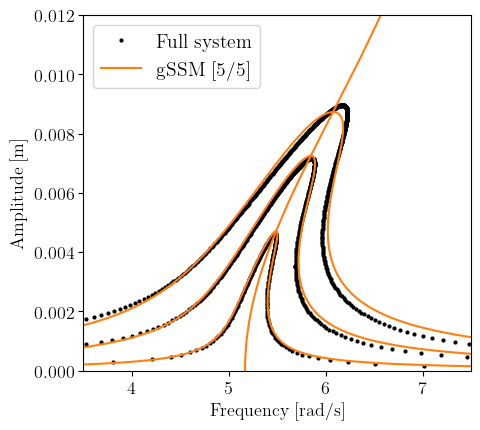

In [32]:
fig = plt.figure(figsize = (5,4.5))


ax = fig.add_subplot(111)

flag = True
for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
    bd = loadmat(src_real + '/data_%s/bd_nd.FRC0.0005/bd.mat' %(i+1))['bd_data']
    bd_data = bd[3,1]
    omega = bd_data[1:,7]
    experimental_omega = np.array(omega, dtype = float)
    response = np.array(bd_data[1:,26])
    experimental_amplitude = [np.max(np.abs(r[outdof,:])) for r in response]
    if flag:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4, label = 'Full system')
    else:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4)
    flag = False

    

for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
       
    OmegaFm_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))
    OmegaFp_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))

    ax.plot(OmegaFm_pade(sample_rs), backbone_pade, '-', c = 'C1')
    ax.plot(OmegaFp_pade(sample_rs), backbone_pade, '-', c='C1')
ax.plot(frequency_Pade.numpy_function(sample_rs), backbone_pade, '-', c='C1', label = 'gSSM [5/5]')


ax.set_xlim(3.5, 7.5)
ax.set_ylim(0, 0.012)

ax.legend(loc='upper left', fontsize = 14.2)


ax.set_xlabel('Frequency [rad/s]')

ax.set_ylabel('Amplitude [m]')
fig.tight_layout()


## Backward integration of an initial condition

In [33]:
def derivative_polar_pade(t,x):
    # assume r, phi order
    dr = np.squeeze(damping_Pade.evaluate(np.array(x[0]).reshape(-1,1)))
    dphi = np.squeeze(frequency_Pade.evaluate(np.array(x[0]).reshape(-1,1)))
    return np.array([dr, dphi])
def derivative_polar_taylor(t,x):
    # assume r, phi order
    dr = np.squeeze(damping_Taylor.evaluate(np.array(x[0]).reshape(-1,1)))
    dphi = np.squeeze(frequency_Taylor.evaluate(np.array(x[0]).reshape(-1,1)))
    return np.array([dr, dphi])

In [34]:
def convert_to_complex(x):
    x1 = np.exp(1j*x[1,:]) * x[0,:]
    x2 = np.exp(-1j*x[1,:]) * x[0,:]
    return np.vstack((x1,x2))
def convert_to_rad_angle(x):
    x1 = np.abs(x)
    x2 = np.angle(x)
    return np.vstack((x1,x2))

In [35]:
ic_for_backward = np.array([0.00062543-0.00036913j, 0.00062543+0.00036913j])

In [36]:
ic_polar_ = np.squeeze(convert_to_rad_angle(ic_for_backward[0]))

In [37]:

T = -45.5
teval = np.linspace(0,T,2000)


In [38]:
from scipy.integrate import solve_ivp

In [39]:

sol_ssm_taylor_backward = solve_ivp(derivative_polar_taylor, [0, T], ic_polar_, t_eval = teval,  atol = 1e-8, method = 'DOP853')
sol_ssm_taylor_backward = convert_to_complex(sol_ssm_taylor_backward.y)
sol_ssm_pade_backward = solve_ivp(derivative_polar_pade, [0, T], ic_polar_, t_eval = teval, atol = 1e-6, method = 'DOP853')
sol_ssm_pade_backward = convert_to_complex(sol_ssm_pade_backward.y)

<lambdifygenerated-7>:2: RuntimeWarning: overflow encountered in power
  return -3.84935872663827e+34*r_0**15 + 2.3612646289689e+29*r_0**13 - 1.50793346027548e+24*r_0**11 + 1.03268695324083e+19*r_0**9 - 80534980448868.6*r_0**7 + 803993769.866588*r_0**5 - 19707.1397155404*r_0**3 - 0.00190777538744291*r_0
<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in add
  return -3.84935872663827e+34*r_0**15 + 2.3612646289689e+29*r_0**13 - 1.50793346027548e+24*r_0**11 + 1.03268695324083e+19*r_0**9 - 80534980448868.6*r_0**7 + 803993769.866588*r_0**5 - 19707.1397155404*r_0**3 - 0.00190777538744291*r_0
<lambdifygenerated-6>:2: RuntimeWarning: overflow encountered in power
  return -2.84888614362198e+40*r_0**16 + 1.70261882038519e+35*r_0**14 - 1.06239021214216e+30*r_0**12 + 7.04144679214576e+24*r_0**10 - 5.09968583839874e+19*r_0**8 + 425032445383959.0*r_0**6 - 4581040982.809*r_0**4 + 93552.6939497371*r_0**2 + 5.1680607373178
<lambdifygenerated-6>:2: RuntimeWarning: invalid value enco

(-46.0, -28.0)

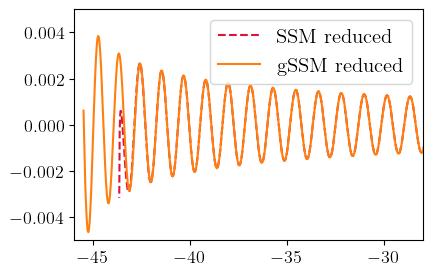

In [40]:
ff = plt.figure(figsize = (4.5, 3))
ax = ff.add_subplot(111)

ax.plot(teval[:-81], np.real(sol_ssm_taylor_backward[0,:]), '--', c='Crimson',  label = 'SSM reduced')
ax.plot(teval, np.real(sol_ssm_pade_backward[0,:]), '-', c='C1',  label = 'gSSM reduced')


ax.legend(loc = 'upper right', fontsize = 15)
ax.set_ylim(-0.005, 0.005)
ax.set_xlim(-46, -28)